# **DATA ANAYSIS AND RESULTS**
### Load the datasets
We will work on the filtered versions to be more efficient. Also load the mapping files to reconstruct the original names from the numerical values.

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

# FIREWALL LOGS
data_firewall = pd.read_csv('../MC2-CSVFirewallandIDSlogs/Firewall_global_filtered.csv')
# IDS LOGS
data = pd.read_csv('../MC2-CSVFirewallandIDSlogs/IDS_global_filtered.csv')

In [36]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')
# load the mapping files
operation_mapping_path = '../MC2-CSVFirewallandIDSlogs/operation_mapping.txt'
syslog_priority_mapping_path = '../MC2-CSVFirewallandIDSlogs/syslog_priority_mapping.txt'
message_code_mapping_path = '../MC2-CSVFirewallandIDSlogs/message_code_mapping.txt'
direction_mapping_path = '../MC2-CSVFirewallandIDSlogs/direction_mapping.txt'
protocol_mapping_path = '../MC2-CSVFirewallandIDSlogs/protocol_mapping.txt'
label_mapping_path = '../MC2-CSVFirewallandIDSlogs/label_mapping.txt'
# read the mappings into dictionaries
def load_mapping(file_path):
    with open(file_path, 'r') as file:
        mapping = {}
        for line in file:
            key, value = line.strip().rsplit(': ', 1)
            mapping[int(value)] = key
    return mapping

operation_mapping = load_mapping(operation_mapping_path)
syslog_priority_mapping = load_mapping(syslog_priority_mapping_path)
message_code_mapping = load_mapping(message_code_mapping_path)
direction_mapping = load_mapping(direction_mapping_path)
protocol_mapping = load_mapping(protocol_mapping_path)
label_mapping = load_mapping(label_mapping_path)

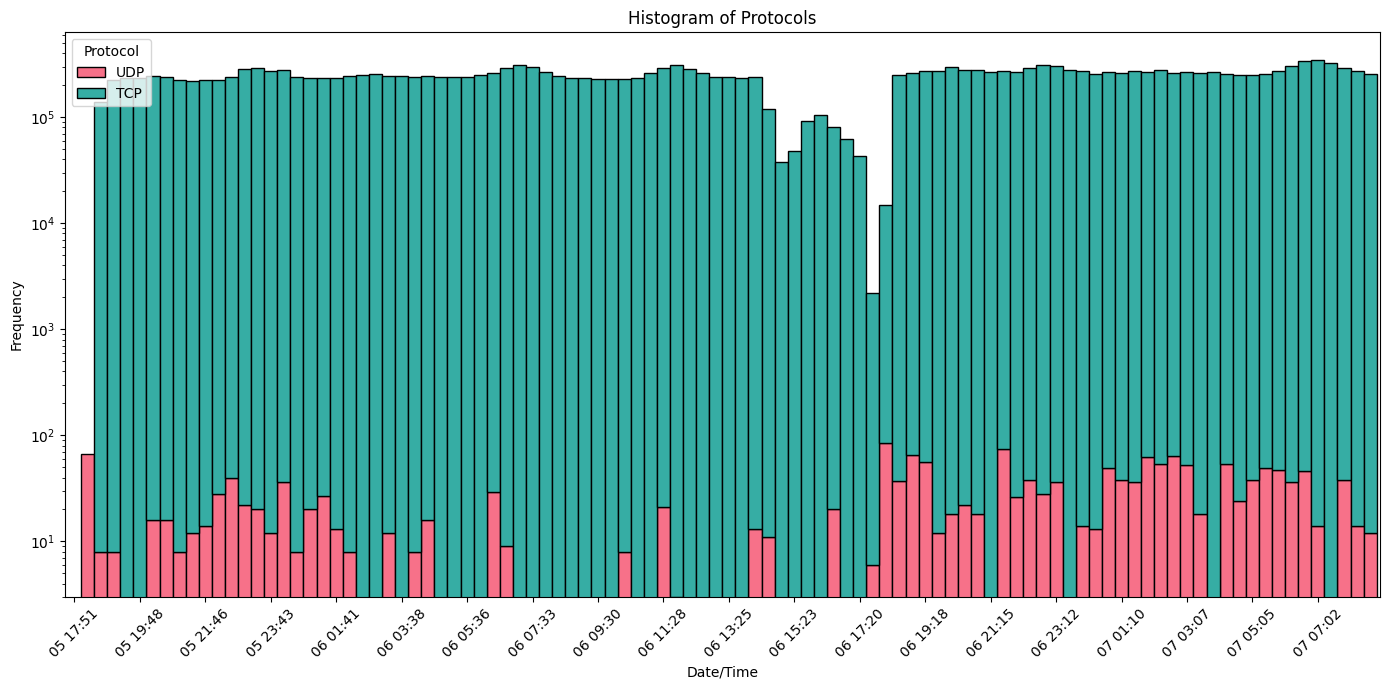

In [38]:
filtered_protocols = data_firewall
# Get the unique services
unique_services = filtered_protocols['Protocol'].unique()
# Assign a different color to each service
colors = sns.color_palette('husl', len(unique_services))
color_mapping = dict(zip(unique_services, colors))
# Convert 'Date/time' to datetime
filtered_protocols['Date/time'] = pd.to_datetime(data_firewall['Date/time'], format='%d %H:%M:%S')
# Bin the data and prepare for stacking
bins = pd.date_range(start=filtered_protocols['Date/time'].min(), 
                     end=filtered_protocols['Date/time'].max(), 
                     periods=101)
stacked_data = {
    service: pd.cut(filtered_protocols[filtered_protocols['Protocol'] == service]['Date/time'], bins=bins).value_counts(sort=False)
    for service in unique_services
}

# Create a DataFrame for the stacked data
stacked_df = pd.DataFrame(stacked_data, index=bins[:-1]).fillna(0)

# Plot the stacked histogram
plt.figure(figsize=(14, 7))
stacked_df.plot(kind='bar', stacked=True, color=[color_mapping[service] for service in unique_services], edgecolor='black', width=1, ax=plt.gca())

plt.xlabel('Date/Time')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Protocols')
# build a legend so that for the value 0 TCP is shown, for value 1 UDP is shown
plt.legend(title='Protocol', labels=['UDP', 'TCP'])
plt.xticks(ticks=range(0, len(bins)-1, max(1, len(bins)//20)), labels=[bin.strftime('%d %H:%M') for bin in bins[:-1]][::max(1, len(bins)//20)], rotation=45)
plt.tight_layout()
plt.show()


In [39]:
# find all the uniques Destination services that use the UDP protocol (value 1)
udp_services = data_firewall[data_firewall['Protocol'] == 1]
udp_services = udp_services[udp_services['Syslog priority'].isin([0,1])]
# remove all the entries that contain the _ character
udp_services = udp_services[~udp_services['Destination service'].str.contains('_')]
# print the occurrences of each unique value in the Destination service column
print(udp_services['Destination service'].value_counts())
# write to csv
udp_services.to_csv('udp_services.csv', index=False)
print(len(udp_services['Destination service'].value_counts()))

Destination service
domain         752
netbios-ns     130
syslog           8
netbios-dgm      2
Name: count, dtype: int64
4


### Preliminary Analysis
First, let us extract all the source IPs that peformed some sort of suspect activities in the network.

In [40]:
# read the mapping between the classification number and the classification name
# Store the elements of the first column in a vector
first_col_vector = []
with open('../MC2-CSVFirewallandIDSlogs/classification_mapping.txt', 'r') as file:
    for line in file:
        name, number = line.strip().split(': ')
        first_col_vector.append(name)
print(first_col_vector)

# select only the col ' sourceIP' that committed ' Potential Corporate Privacy Violation'
sourceIP_potential_corporate_privacy_violation = data[data['classification'] == 1]['sourceIP']
print("sourceIP_potential_corporate_privacy_violation: ", len(sourceIP_potential_corporate_privacy_violation))
# get the unique entries and print the length
sourceIP_potential_corporate_privacy_violation_unique = sourceIP_potential_corporate_privacy_violation.unique()
print("sourceIP_potential_corporate_privacy_violation_unique: ", len(sourceIP_potential_corporate_privacy_violation_unique))

# select only the col ' sourceIP' from the rows where the value of the ' classification' column is ' Attempted Information Leak'
sourceIP_attempted_information_leak = data[data['classification'] == 3]['sourceIP']
print("sourceIP_attempted_information_leak: ", len(sourceIP_attempted_information_leak))
# get the unique entries and print the length
sourceIP_attempted_information_leak_unique = sourceIP_attempted_information_leak.unique()
# get the piority of the packets that are classified as ' Potential Corporate Privacy Violation'
sourceIP_bad_traffic = data[data['classification'] == 4]['sourceIP']

# aggregate all the sourceIPs that are responsible for the aforementioned suspect activities
suspectIPs = pd.concat([sourceIP_potential_corporate_privacy_violation, sourceIP_attempted_information_leak, sourceIP_bad_traffic])
# keep only the unique entries
suspectIPs = suspectIPs.unique()
number_unique_IPs = len(suspectIPs)
# if they all start with 172, print the number of such entries
suspectIPs = [ip for ip in suspectIPs if ip.startswith('172')]
if len(suspectIPs) == number_unique_IPs:
    print("All the suspect IPs are inside the network and amount to: ", number_unique_IPs)

['Generic Protocol Command Decode', 'Potential Corporate Privacy Violation', 'Misc activity', 'Attempted Information Leak', 'Potentially Bad Traffic']
sourceIP_potential_corporate_privacy_violation:  434
sourceIP_potential_corporate_privacy_violation_unique:  89
sourceIP_attempted_information_leak:  366
All the suspect IPs are inside the network and amount to:  94


We observe that all the suspect IPs are inside the network and correspond to individual workstations. These are likely infected machines that can be remotely activated and controlled by malicious parties to perform illegal activities, such as DDoS attacks, port scanning, data exfiltration, etc. The infection probably happened due to bad practices on the part of the workers, such as opening malicious email attachments, visiting dangerous websites, using infected drivers, or using weak passwords.

Now let us investigate which are the most common and least common protocols used in the network, according to the firewall logs. Exclude those labelled as tcp in the latter case.

In [41]:
# extract the rows corresponding to the most common destination services from data_firewall
most_common_services = data_firewall['Destination service'].value_counts().head(10)
print("Most common services \n", most_common_services)

data_firewall_ports = data_firewall[~data_firewall['Destination service'].astype(str).str.contains('_tcp', na=False)]
least_common_services = data_firewall_ports['Destination service'].value_counts().tail(10)
print("Least common services \n",least_common_services)

Most common services 
 Destination service
http          21331506
6667_tcp       2329914
ftp               1825
domain             752
22_tcp             538
1026_udp           194
netbios-ns         130
auth                62
1025_udp            50
https               42
Name: count, dtype: int64
Least common services 
 Destination service
9785_udp      2
11353_udp     2
20871_udp     2
22960_udp     2
15898_udp     2
17280_udp     2
30226_udp     2
44652_udp     2
ingreslock    1
ms-sql-m      1
Name: count, dtype: int64


There are already some interesting findings in this preliminary analysis. We note that the second most used port is 6667 with TCP protocol, which is usually associated with Internet Relay Chat servers. These should not be accessed from within the banck network. 
Though the most interesting information stems from the least common services, specifically those labelled as `ingreslock` and `ms-sql-m`. The former refers to a backdoor vulnerability used to gain root access to a machine. The latter is an exploit for the Microsoft SQL Server, which can be used to gain unauthorized access to the database. It is the starting point of a privilege escalation attack, as well as data exfiltration procedures. Both are very dangerous and should be investigated further. Let us extract the logs corresponding to these services.

In [42]:
# replace numeric codes with corresponding descriptive names
data_firewall_ports.loc[:, 'Operation'] = data_firewall_ports['Operation'].map(operation_mapping)
data_firewall_ports.loc[:, 'Syslog priority'] = data_firewall_ports['Syslog priority'].map(syslog_priority_mapping)
data_firewall_ports.loc[:, 'Message code'] = data_firewall_ports['Message code'].map(message_code_mapping)
data_firewall_ports.loc[:, 'Direction'] = data_firewall_ports['Direction'].map(direction_mapping)
data_firewall_ports.loc[:, 'Protocol'] = data_firewall_ports['Protocol'].map(protocol_mapping)
# extract the logs of interest
ingreslock = data_firewall_ports[data_firewall_ports['Destination service'] == 'ingreslock']
print(ingreslock.to_string())
ms_sql_m = data_firewall_ports[data_firewall_ports['Destination service'] == 'ms-sql-m']
print(ms_sql_m.to_string())

                   Date/time Syslog priority Operation  Message code Protocol    Source IP Destination IP  Source port  Destination port Destination service Direction
13322108 1900-01-06 18:16:59            Info      Deny  ASA-6-106015      TCP  10.32.0.100    172.28.29.9           80              1524          ingreslock       NaN
                  Date/time Syslog priority Operation  Message code Protocol    Source IP Destination IP  Source port  Destination port Destination service Direction
3314909 1900-01-05 23:45:29            Info      Deny  ASA-6-106015      TCP  10.32.0.100   172.28.29.20           80              1434            ms-sql-m       NaN


In both cases the firewall is reporting that a critical connection was made and a command successfully executed. We can see that the database was already hacked on the first day before midnight, while the backdoor was exploited later on. We will contextualize these events in light of the following events hereinafter. Unfortunately, this information is not present in the IDS logs, only in the firewall logs.

Now let us visualize the distribution of suspect connections during the time frame covered by the logs, as well as the IPs responsible for them. Select only the IDS logs that are labelled as either Potential Corporate Privacy Violation, Potentially Bad Traffic, or Attempted Information Leak.

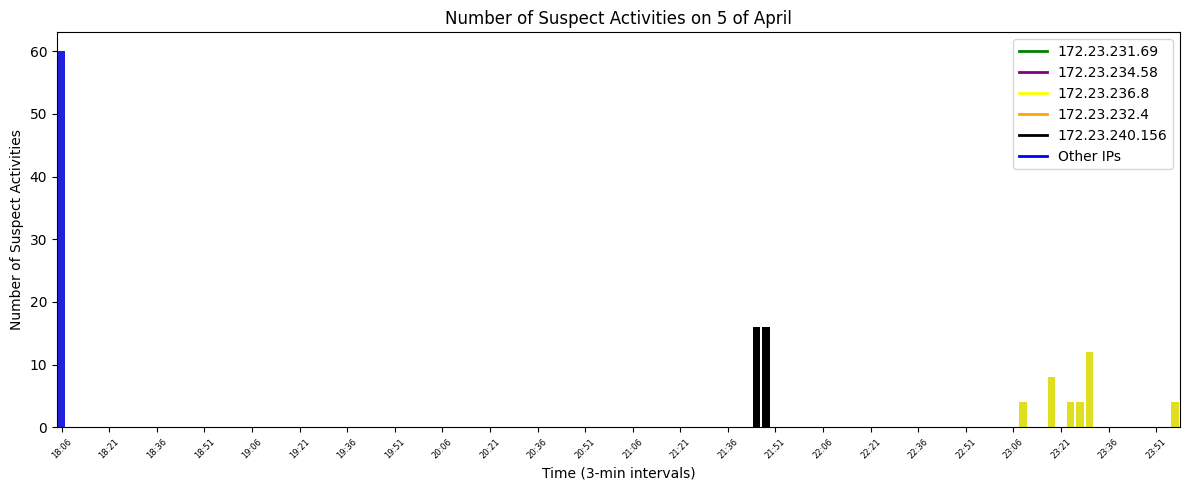

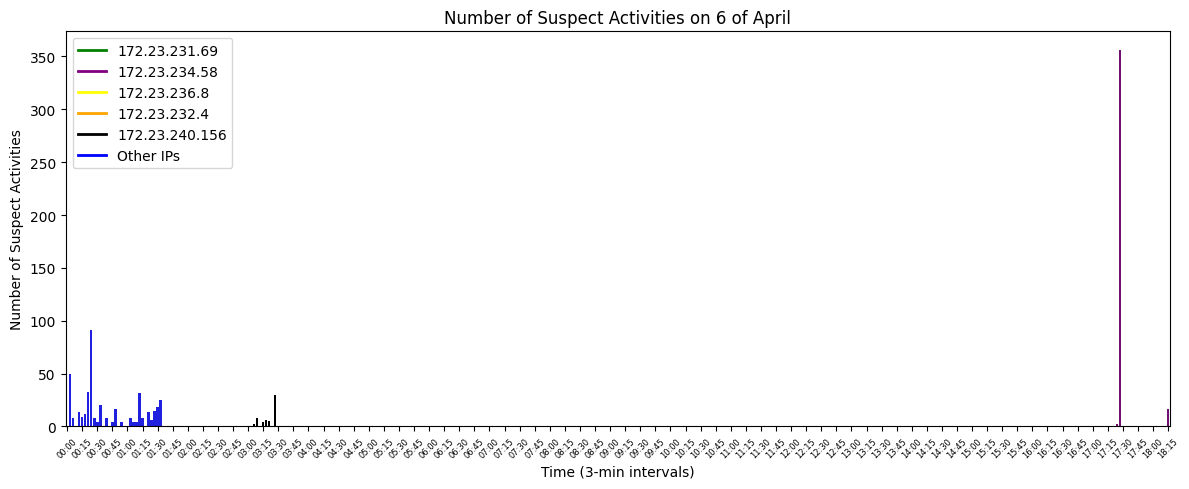

In [43]:
# Filter data for classifications 1, 3, and 4
suspect_activities = data[data['classification'].isin([1, 3, 4])]

# Count the number of activities per source IP
activity_counts = suspect_activities['sourceIP'].value_counts().reset_index()
activity_counts.columns = ['sourceIP', 'count']

# Convert 'time' to datetime. Adjust the format string if your actual data differs.
data['time'] = pd.to_datetime(data['time'], format='%d %H:%M')

# Filter the data for classifications 1, 3, and 4
suspect_activities = data[data['classification'].isin([1,3,4])]

# Set the 'time' column as the index so we can resample easily
suspect_activities = suspect_activities.set_index('time')

# Resample every 3 minutes and count activities
five_min_counts = suspect_activities.resample('3T').size()

# Get the unique days present in the data
unique_days = five_min_counts.index.normalize().unique()

# Get the top 5 source IPs that carried out the most attacks
top_5_ips = activity_counts.iloc[:5]['sourceIP']

for day in unique_days:
    # Filter data for this particular day
    day_start = day
    day_end = day + pd.Timedelta(days=1)
    day_data = five_min_counts[(five_min_counts.index >= day_start) & (five_min_counts.index < day_end)]
    
    # Create a figure for this day
    plt.figure(figsize=(12,5))
    
    # Assign colors based on whether the source IP is in the top 5
    colors = ['green' if ip == top_5_ips.values[0] else
              'purple' if ip == top_5_ips.values[1] else
              'yellow' if ip == top_5_ips.values[2] else
              'orange' if ip == top_5_ips.values[3] else
              'black' if ip == top_5_ips.values[4] else
              'blue' for ip in suspect_activities['sourceIP']]

    
    sns.barplot(x=day_data.index, y=day_data.values, palette=colors)
    plt.xlabel('Time (3-min intervals)')
    plt.ylabel('Number of Suspect Activities')
    plt.title(f'Number of Suspect Activities on {day.date().day} of April')

    # Define custom ticks for this day's data
    x_labels = day_data.index
    num_points = len(x_labels)
    
    # For example, show a tick every 5 samples
    tick_positions = range(0, num_points, 5)
    tick_labels = [x_labels[i].strftime('%H:%M') for i in tick_positions]  # Just time for this day
    
    plt.xticks(tick_positions, tick_labels, rotation=45, fontsize=6)
    plt.tight_layout()
    # add a legend for the color mapping with the IPs
    plt.legend(handles=[plt.Line2D([0], [0], color='green', lw=2, label=top_5_ips.values[0]),
                       plt.Line2D([0], [0], color='purple', lw=2, label=top_5_ips.values[1]),
                       plt.Line2D([0], [0], color='yellow', lw=2, label=top_5_ips.values[2]),
                       plt.Line2D([0], [0], color='orange', lw=2, label=top_5_ips.values[3]),
                       plt.Line2D([0], [0], color='black', lw=2, label=top_5_ips.values[4]),
                       plt.Line2D([0], [0], color='blue', lw=2, label='Other IPs')])
    plt.show()

These events are to be investigated further and form the foundation of most of our conclusions.

# **CONCLUSIONS**
### 1 - Increase in connections over 6667_tcp 
There is an increasingly large presence of network connections that use 6667 as destination port,
commonly used for IRC (Internet Relay Chat), which is an activity that violates the Bank of Money
policy. The first occurrence of such event is on April 5th at 20:25:35 by source IP 172.23.234.254, which
corresponds to an individual workstation inside of the network. Actually, the connections using port
6667 tcp are the second most common ones, preceded only by the port 80 accessed with http protocol.
The large use of the former is a fact to be investigated and is a symptom of the upcoming events, while
the latter is not problematic per se. Also, this service supports file transfer capabilities, which could
pose a security risk for sensitive data. Moreover, there is a consistent number of connections over port
22 TCP, which is commonly used for SSH and SCP protocols. Hackers often target port 22 because they
could potentially do unlimited damage if they can log onto a remote device. Because of the risk, many
organizations will turn off port 22, while the bank left it open. This could be a sign of external actors
transferring data through the TCP protocol from compromised workstations to external servers.

In [44]:
# find all the entries where the destination Port is 6667
temp = data_firewall[data_firewall['Destination port'] == 6667]
print("data_breach: ", len(temp))

# now ge the 5 most used Destination ports
destination_ports = data_firewall['Destination port'].value_counts().reset_index()
destination_ports.columns = ['Destination port', 'count']
destination_ports = destination_ports.iloc[:10]
print("\n", destination_ports)
# find the first occurence of the port 6667
first_occurence = data_firewall[data_firewall['Destination port'] == 6667].iloc[0]

print("\n First occurence: \n")
print(first_occurence)
# now get the most used Destination services
destination_services = data_firewall['Destination service'].value_counts().reset_index()
destination_services.columns = ['Destination service', 'count']
destination_services = destination_services.iloc[:5]
print("\n Destination services: \n", destination_services)

data_breach:  2329914

    Destination port     count
0                80  21331506
1              6667   2329914
2                21      1825
3                53       752
4                22       538
5              1026       199
6               137       130
7               113        62
8              1025        52
9               443        42

 First occurence: 

Date/time              1900-01-05 20:25:35
Syslog priority                          0
Operation                                1
Message code                             9
Protocol                                 0
Source IP                   172.23.234.254
Destination IP                  10.32.5.51
Source port                           1230
Destination port                      6667
Destination service               6667_tcp
Direction                                1
Name: 1201706, dtype: object

 Destination services: 
   Destination service     count
0                http  21331506
1            6667_tcp   2329914
2

In [45]:
# filter the data for the firewall IPs
firewall_data_ssh = data_firewall[data_firewall['Destination port'].isin([22])]
# convert the 'Date/time' column to datetime format
firewall_data_ssh['datetime'] = pd.to_datetime(firewall_data_ssh['Date/time'], format='%d %H:%M:%S')
# Set the 'datetime' column as the index
firewall_data_ssh.set_index('datetime', inplace=True)
# resample the data in 8-minute intervals and count the number of activities
ssh_counts = firewall_data_ssh.resample('8T').size()
# print the first 5 entries
print(len(ssh_counts))

51


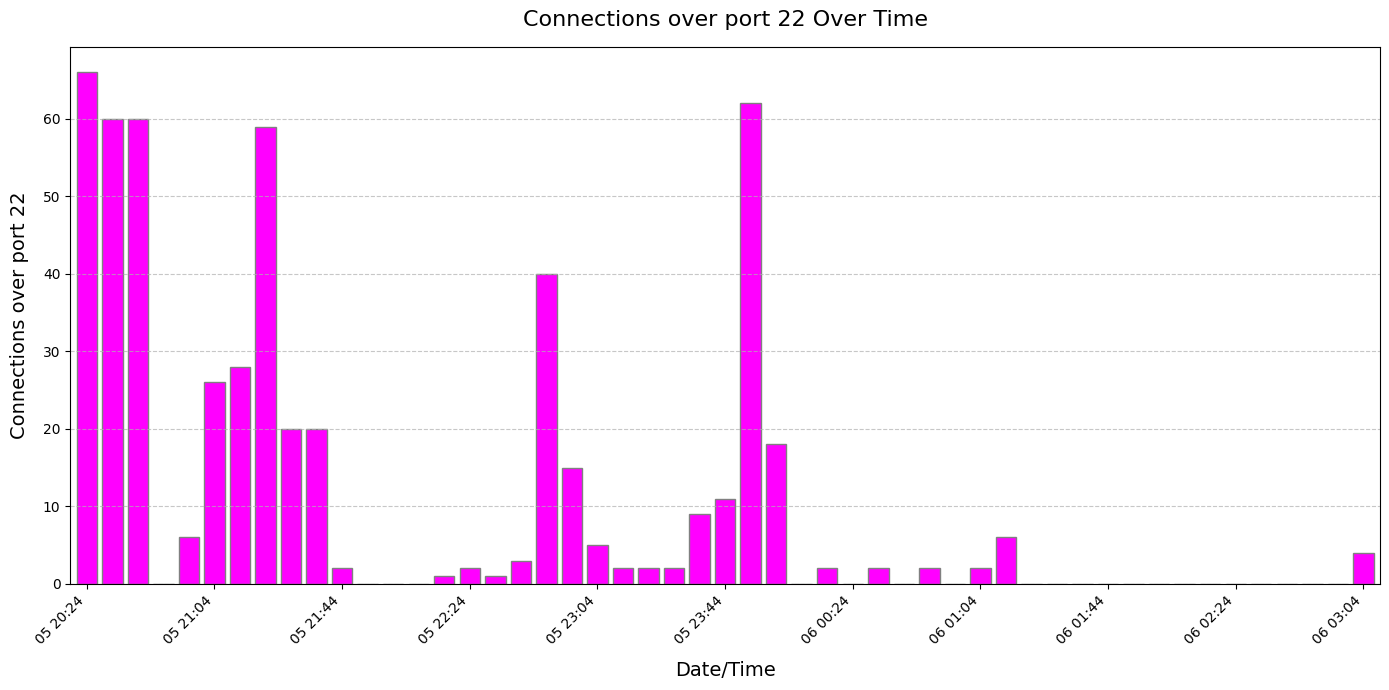

In [46]:
# style and plot the histogram
plt.figure(figsize=(14, 7))
ssh_counts.plot(kind='bar', color='magenta', width=0.8, edgecolor='gray')
plt.xlabel('Date/Time', fontsize=14, labelpad=10)
plt.ylabel('Connections over port 22', fontsize=14, labelpad=10)
plt.title('Connections over port 22 Over Time', fontsize=16, pad=15)
# customize x-axis ticks for better readability
num_ticks = 10
tick_positions = range(0, len(ssh_counts), max(1, len(ssh_counts) // num_ticks))
tick_labels = [ssh_counts.index[i].strftime('%d %H:%M') for i in tick_positions]
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45, fontsize=10, ha='right')
# add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 2 - First attack to the firewall and MSQL exploit
We observe the first attempts to hack into the bank servers between 21:47 and 21:48 on April 5th.
There are several logs labeled as suspicious inbound connections to the MSSQL, Oracle SQL, mySQL,
and PostgreSQL servers. The source IP is 172.23.240.156, likely an infected workstation that is part
of a botnet set up by the attackers. The destination is 172.23.0.1, the firewall internal to the bank network, marking the first of several attacks that target it. Later on, other IPs such as 172.23.236.8,
172.23.231.69, 172.23.234.58 and 172.23.232.4 also target the firewall. The attacks occur between 23:30
of the 5th and 03:20 of the 6th, all during the closing hours of the bank, leaving it completely incapable
of reacting to the danger. So far, we have identified five compromised workstations. While several
future connections will still be classified as suspect and dangerous, the above ones are actually the
last ones labeled as potential attacks. Moreover, at 23:45:29 of the 5th, the firewall logs show that an
hack attempy to the MSSQL server by the means of the `ms-sql-m` exploit that targets Microsoft SQL
database servers. This is was supposed to be the beginning of a privilege escalation attack, but the
firewall manages to deny the connection and block the attack. The attackers would have been able to
access the database and exfiltrate data at their will. Clearly, some external agents are targeting the
Bank of Money with a series of cyberattacks, of which this is just the start. In facts, a similar exploit
called `ms-sql-s is` used four times by external servers to attack the company, between 18:31 of the 5th
and 21:51 of the 6th. The most notable one happens at 2:48 of the 6th over port 6667 and is intercepted
by the firewall interface to the internet. None of these attempts are successful, as they are all denied
by the network defenses.

In [47]:
# define the time range
start_time = '05 21:30'
end_time = '07 21:50'
# convert the 'time' column into a comparable format
data['parsed_time'] = pd.to_datetime(data['time'], format='%d %H:%M')
# convert the range values as well
start_time_parsed = pd.to_datetime(start_time, format='%d %H:%M')
end_time_parsed = pd.to_datetime(end_time, format='%d %H:%M')
# filter rows within the range
filtered_data = data[(data['parsed_time'] >= start_time_parsed) & (data['parsed_time'] <= end_time_parsed)]
# filter the data for the labels of interest
filtered_data = filtered_data[(filtered_data['label'] >= 6) & (filtered_data['label'] <= 12)]
# set the 'time' column as the index
filtered_data.set_index('time', inplace=True)
# select the sourceIPs
sourceIPs = filtered_data['sourceIP']
# print the unique entries of the suspect IPs that were active during this time frame
sourceIPs = sourceIPs.unique()
print("sourceIPs: ", sourceIPs)
# get destination IPs
destinationIPs = filtered_data['destIP']
destinationIPs = destinationIPs.unique()
print("destinationIPs: ", destinationIPs)

sourceIPs:  ['172.23.240.156' '172.23.236.8' '172.23.231.69' '172.23.234.58'
 '172.23.232.4']
destinationIPs:  ['172.23.0.1']


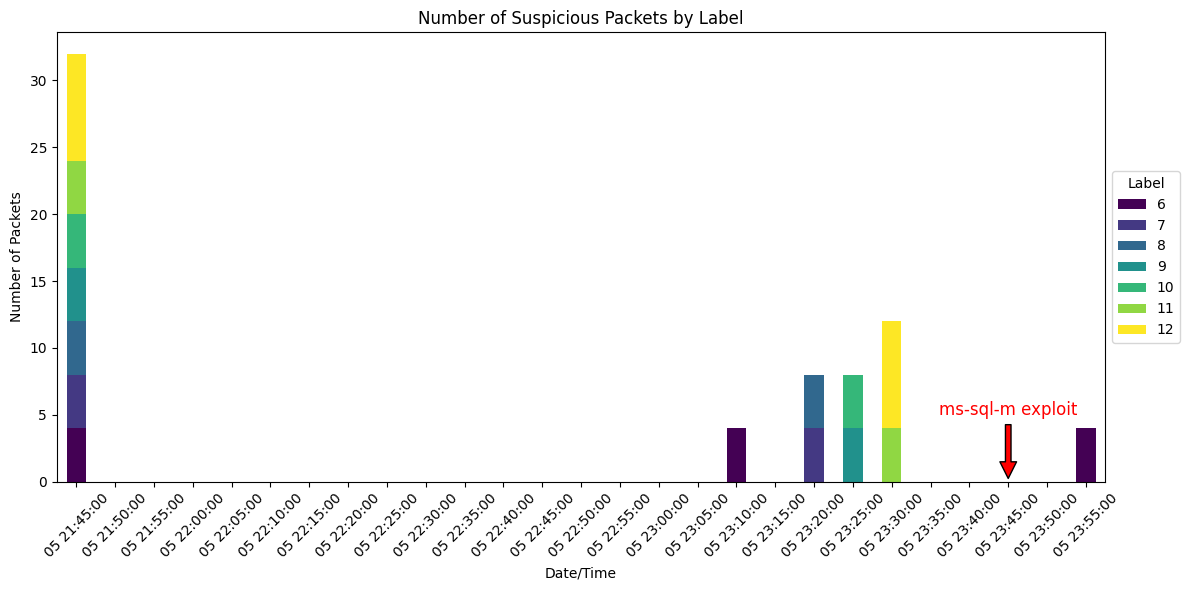

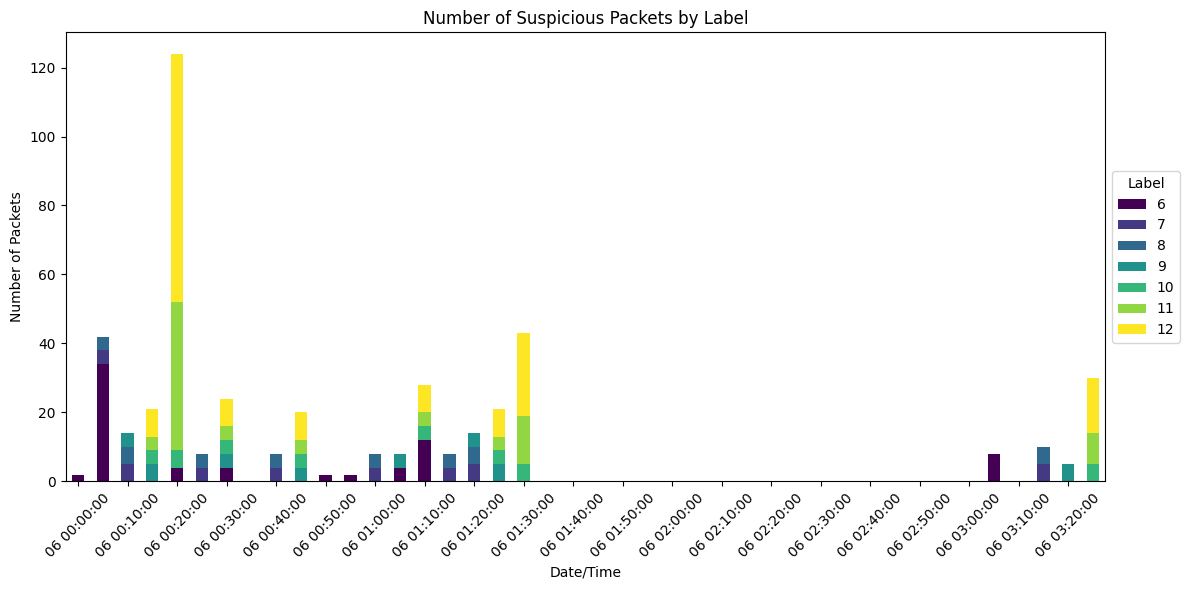

In [48]:
# group the data by day
grouped_data = filtered_data.groupby(filtered_data.index.normalize())

for day, day_data in grouped_data:
    # resample the data in 10-minute intervals and count occurrences for each label
    label_counts = day_data.groupby('label').resample('5T').size().unstack(level=0, fill_value=0)
    
    # style and plot the histogram
    plt.figure(figsize=(12, 6))
    label_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='viridis')
    plt.xlabel('Date/Time')
    plt.ylabel('Number of Packets')
    plt.title(f'Number of Suspicious Packets by Label')
    # display only 20 total labels on the x-axis, homogeneously distributed, for better readability
    num_ticks = 20
    tick_positions = range(0, len(label_counts), max(1, len(label_counts) // num_ticks))
    tick_labels = [label_counts.index[i].strftime('%d %H:%M:%S') for i in tick_positions]
    plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
    # put the legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Label')
    
    # Add a red triangle annotation at the specified date and time
    annotation_time = pd.to_datetime('5 23:45', format='%d %H:%M')
    if annotation_time in label_counts.index:
        plt.annotate(
            'ms-sql-m exploit',
            xy=(label_counts.index.get_loc(annotation_time), label_counts.loc[annotation_time].max()),
            xytext=(label_counts.index.get_loc(annotation_time), label_counts.loc[annotation_time].max() + 5),
            arrowprops=dict(facecolor='red', shrink=0.05),
            fontsize=12,
            ha='center',
            color='red'
        )
    
    plt.tight_layout()
    plt.show()

### 3 - Firewall down and Ingreslock attack
At 17:21:50 on April 6th, the firewall is down due to unclear reasons. In facts, we can
see a sudden drop to zero in the number of network packets analyzed by it. Shortly after this, the IDS logs show a spike in the connections labeled as `ET POLICY DNS Update From External net` between 17:26 and 17:29. All the source IPs are internal from the net and target the DNS using port 53, which is strange given the classification by the IDS. This is likely an attempt from the attackers to exfiltrate data now that the network defenses are not operational. The company manages to bring the firewall back up in a few minutes, at 17:40, but the damage is already done, since the attackers were free to operate during this short time frame. Moreover, at 18:16:59 of the 6th the attackers proceed in using an `ingreslock` vulnerability to gain root access to the internal servers. This vulnerability stems from the fact that the TCP port 1524 was commonly used as a backdoor listening port by attackers after successfully compromising a system, which has happened following the previous attack. The simplicity of exploiting this vulnerability lies in the ability to gain root-level access to the target machine by simply connecting to the open port. While this has been known for a long time,
legacy system like the one of the bank still have it enabled. Even though the malicious connection is denied once again, this fact highlights the lack of basic security measures in place.

First, let us check the logs of the IDS to see if there are any spikes in the suspicious activities coinciding with the firewall going down. We already restricted the logs to make them more readable when conveying important information.

In [49]:
# define the time range
start_time = '06 00:01'
end_time = '06 23:59'

# convert the 'time' column into a comparable format
data['parsed_time'] = pd.to_datetime(data['time'], format='%d %H:%M')
# convert the range values as well
start_time_parsed = pd.to_datetime(start_time, format='%d %H:%M')
end_time_parsed = pd.to_datetime(end_time, format='%d %H:%M')
# filter rows within the range
filtered_data = data[(data['parsed_time'] >= start_time_parsed) & (data['parsed_time'] <= end_time_parsed)]
# filter the data for the labels of interest
filtered_data = filtered_data[(filtered_data['label'] <= 4)]
# reconstruct the label column with the original values from the mapping
filtered_data['label'] = filtered_data['label'].map(label_mapping)
# set the 'time' column as the index
filtered_data.set_index('time', inplace=True)

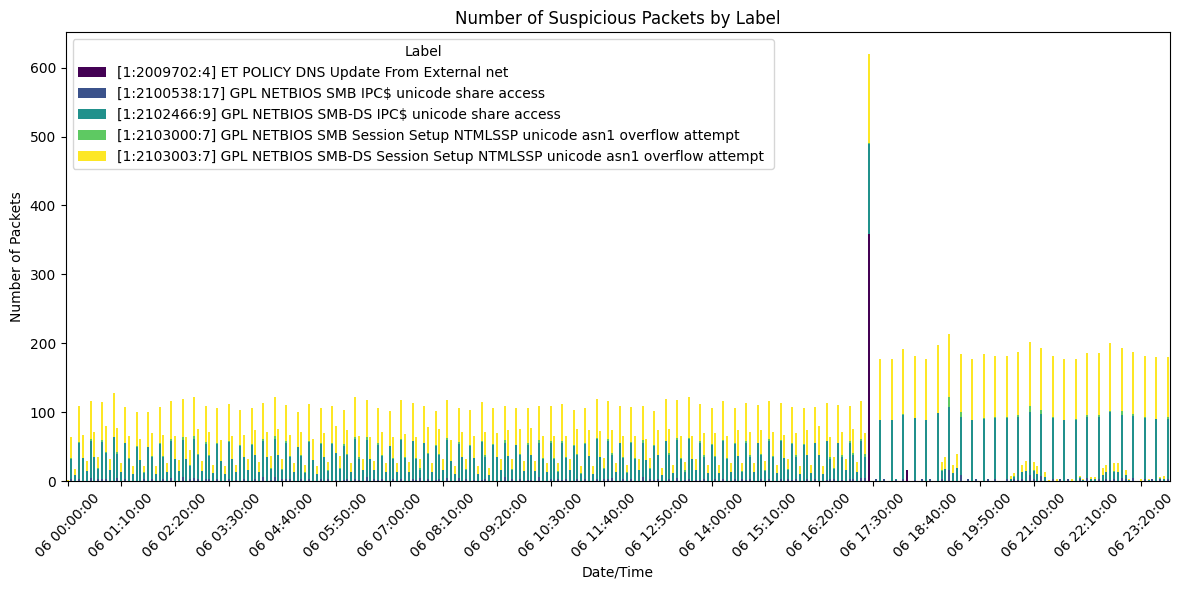

Bin with maximum value:  label
[1:2009702:4] ET POLICY DNS Update From External net                                    1900-01-06 17:25:00
[1:2100538:17] GPL NETBIOS SMB IPC$ unicode share access                                1900-01-06 19:10:00
[1:2102466:9] GPL NETBIOS SMB-DS IPC$ unicode share access                              1900-01-06 17:25:00
[1:2103000:7] GPL NETBIOS SMB Session Setup NTMLSSP unicode asn1 overflow attempt       1900-01-06 19:10:00
[1:2103003:7] GPL NETBIOS SMB-DS Session Setup NTMLSSP unicode asn1 overflow attempt    1900-01-06 17:25:00
dtype: datetime64[ns]
Logs for the bin with maximum value: 
                          sourceIP  sourcePort       destIP  destPort  \
time                                                                   
1900-01-06 17:25:00  172.23.1.110        1029  172.23.0.10       445   
1900-01-06 17:25:00  172.23.1.110        1029  172.23.0.10       445   
1900-01-06 17:25:00  172.23.1.110        1072  172.23.0.10       445   
1900-01-

In [ ]:
# Resample the entire dataset in 5-minute intervals and count occurrences for each label
label_counts = filtered_data.groupby('label').resample('5T').size().unstack(level=0, fill_value=0)

# Style and plot the histogram
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='viridis')

plt.xlabel('Date/Time')
plt.ylabel('Number of Packets')
plt.title('Number of Suspicious Packets by Label')

# Display only 20 total labels on the x-axis, homogeneously distributed, for better readability
num_ticks = 20
tick_positions = range(0, len(label_counts), max(1, len(label_counts) // num_ticks))
tick_labels = [label_counts.index[i].strftime('%d %H:%M:%S') for i in tick_positions]
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
# Legend inside the plot
plt.legend(title='Label')
plt.tight_layout()
plt.show()
# # extract the bin with maximum value
# max_bin = label_counts.idxmax()
# # print the bin with maximum value
# print("Bin with maximum value: ", max_bin)
# # get the logs for the bin with maximum value
# max_bin_logs = filtered_data.loc[max_bin]
# # print the logs
# print("Logs for the bin with maximum value: \n", max_bin_logs)

As we will assess in the next steps, the spike in connections blocked by the IDS which correspond to `GPL NETBIOS SMB-DS IPC$ unicode share access` occur right before the firewall goes down. We observe that the firewall is not operational between 17:21:40 and 17:40:00. 

In [74]:
# filter the data for the firewall IPs
firewall_data = data_firewall[data_firewall['Destination IP'].isin(['172.23.0.1', '10.32.0.1'])]
# convert the 'Date/time' column to datetime format
firewall_data['datetime'] = pd.to_datetime(firewall_data['Date/time'], format='%d %H:%M:%S')
# define the time range
start_time = '06 17:21:50'
end_time = '06 17:40:00'
start_time_parsed = pd.to_datetime(start_time, format='%d %H:%M:%S')
end_time_parsed = pd.to_datetime(end_time, format='%d %H:%M:%S')
# filter rows within the range
filtered_data = firewall_data[(firewall_data['datetime'] >= start_time_parsed) & (firewall_data['datetime'] <= end_time_parsed)]
print('Firewall logs within the time range:')
print(filtered_data)
# NOTE: there are no firewall logs in the specified time range
# Set the 'datetime' column as the index
firewall_data.set_index('datetime', inplace=True)
# resample the data in 8-minute intervals and count the number of activities
activity_counts = firewall_data.resample('8T').size()
# select the bin with the lowest number of activities, which is the one of out interest
min_bin = activity_counts.idxmin()
min_value = activity_counts.min()

Firewall logs within the time range:
Empty DataFrame
Columns: [Date/time, Syslog priority, Operation, Message code, Protocol, Source IP, Destination IP, Source port, Destination port, Destination service, Direction, datetime]
Index: []


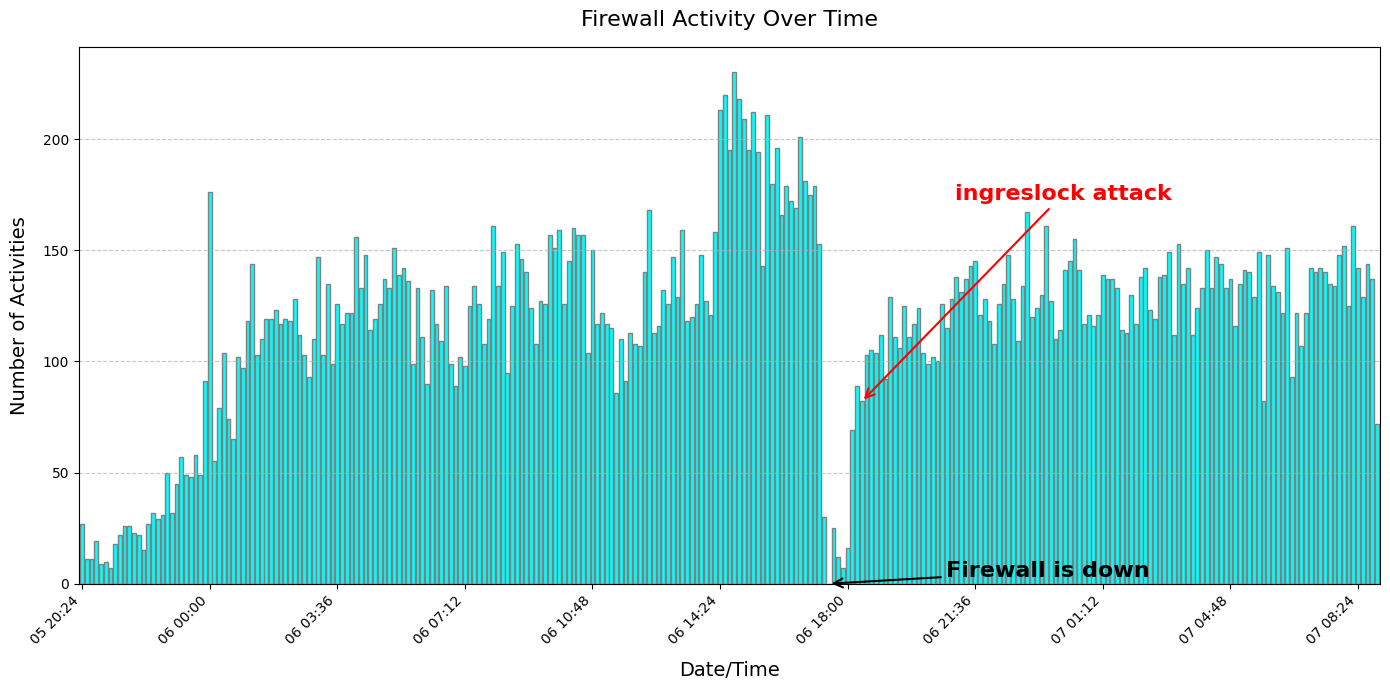

In [106]:
# style and plot the histogram
plt.figure(figsize=(14, 7))
activity_counts.plot(kind='bar', color='cyan', width=0.8, edgecolor='gray')
plt.xlabel('Date/Time', fontsize=14, labelpad=10)
plt.ylabel('Number of Activities', fontsize=14, labelpad=10)
plt.title('Firewall Activity Over Time', fontsize=16, pad=15)
# customize x-axis ticks for better readability
num_ticks = 10
tick_positions = range(0, len(activity_counts), max(1, len(activity_counts) // num_ticks))
tick_labels = [activity_counts.index[i].strftime('%d %H:%M') for i in tick_positions]
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45, fontsize=10, ha='right')
# add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
# annotate the bar with the lowest value, so that it is clear the firewall is down for a short period
plt.annotate(
    f'Firewall is down',
    xy=(activity_counts.index.get_loc(min_bin), min_value),
    xytext=(activity_counts.index.get_loc(min_bin), min_value + 2),
    ha='center',
    arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
    fontsize=16,
    fontweight='bold',
    verticalalignment='bottom',
    textcoords='offset points',
    color='black'
)
# add a red annotation for the ingreslock attack
ingreslock_time = pd.to_datetime('6 18:24', format='%d %H:%M')
if ingreslock_time in activity_counts.index:
    plt.annotate(
        'ingreslock attack',
        xy=(activity_counts.index.get_loc(ingreslock_time), activity_counts.loc[ingreslock_time]),
        xytext=(activity_counts.index.get_loc(ingreslock_time) - 20, activity_counts.loc[ingreslock_time] + 60),
        ha='center',
        arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
        fontsize=16,
        fontweight='bold',
        verticalalignment='bottom',
        textcoords='offset points',
        color='red'
    )
plt.tight_layout()
plt.show()

### 4 - Attempted data exfiltration
After some minutes, the firewall comes back up, contextually to a huge spike in the FTP connections, at
around 18:30. This activity clearly violates the bank policy and can be interpreted as several attempts
of information leakage by the botnet, which has expanded noticeably. All the connections are blocked
by the firewall, which is doing a good job at limiting the potential damage suffered by the bank.
The 286 IPs involved in this activity are again all internal to the network, once again confirming the
hypothesis above. The seven destination IPs correspond to websites, which are accessed through the
port 21. Although the attackers did not manage to get access directly to the databases, but only to
data stored on individual workstations, they still gained access to potentially critical data.

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# define the time range
start_time = '06 12:00'
end_time = '07 22:00'
# convert the 'time' column into a comparable format
data_firewall['parsed_time'] = pd.to_datetime(data_firewall['Date/time'], format='%d %H:%M:%S')
start_time_parsed = pd.to_datetime(start_time, format='%d %H:%M')
end_time_parsed = pd.to_datetime(end_time, format='%d %H:%M')
# filter rows within the range
filtered_firewall_data = data_firewall[(data_firewall['parsed_time'] >= start_time_parsed) & (data_firewall['parsed_time'] <= end_time_parsed)]
# filter the data for the firewall IPs and the desired services
filtered_firewall_data = filtered_firewall_data[ 
    (filtered_firewall_data['Destination service'].isin(['ftp']))
]

# convert the 'Date/time' column to datetime format
filtered_firewall_data['datetime'] = pd.to_datetime(filtered_firewall_data['Date/time'], format='%d %H:%M:%S')
filtered_firewall_data.set_index('datetime', inplace=True)
# eesample the data in 10-minute intervals and count occurrences for each service
service_counts = filtered_firewall_data.groupby('Destination service').resample('10T').size().unstack(level=0, fill_value=0)
# get the destination ports
destination_ports = filtered_firewall_data['Destination port'].unique()
print("destination_ports: ", destination_ports)

destination_ports:  [21]


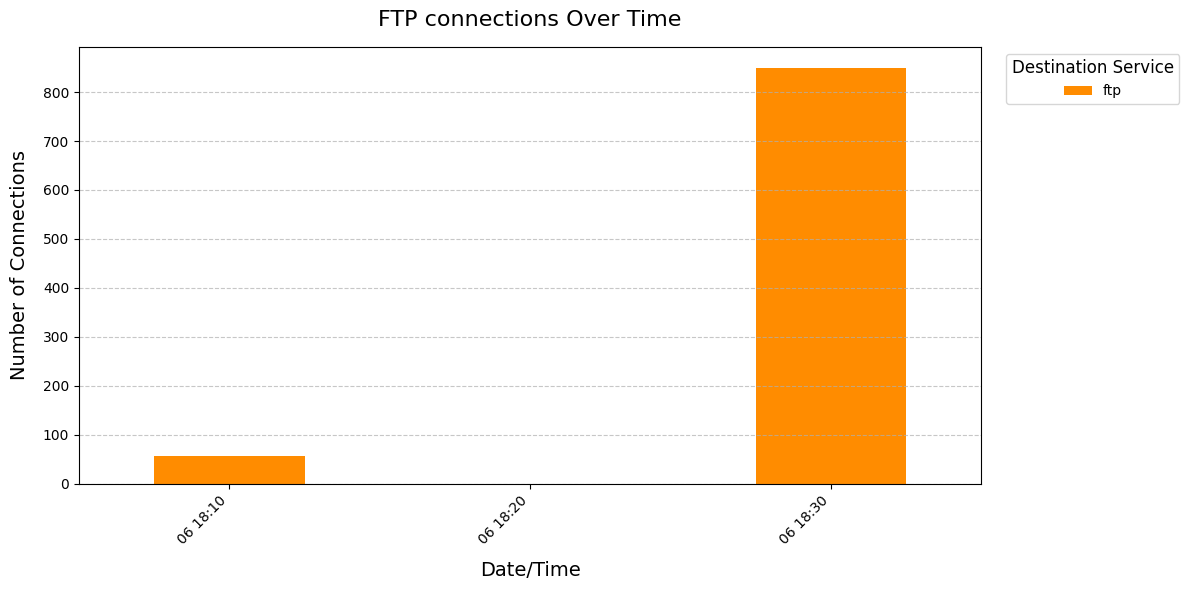

In [89]:
# plot the histogram
plt.figure(figsize=(12, 6))  
# use custom colors for each service
colors = {'ftp': 'darkorange'}
service_counts.plot(
    kind='bar',
    stacked=True,
    color=[colors[col] for col in service_counts.columns], 
    ax=plt.gca()
)
plt.xlabel('Date/Time', fontsize=14, labelpad=10)
plt.ylabel('Number of Connections', fontsize=14, labelpad=10)
plt.title('FTP connections Over Time', fontsize=16, pad=15)
num_ticks = 10
tick_positions = range(0, len(service_counts), max(1, len(service_counts) // num_ticks))
tick_labels = [service_counts.index[i].strftime('%d %H:%M') for i in tick_positions]
plt.xticks(
    ticks=tick_positions,
    labels=tick_labels,
    rotation=45,
    fontsize=10,
    ha='right'  
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# add legend 
plt.legend(
    title="Destination Service",
    title_fontsize=12,
    fontsize=10,
    loc='upper left',
    bbox_to_anchor=(1.02, 1)
)
plt.tight_layout()
plt.show()

### 5 - Anomalous activity, possible DDOS attack
The last noticeable events we observed are the following. First, a sharp increase in the activity of
IP 172.23.252.10, which was dormant before the attack to the firewall. After this event, it becomes
extremely active and takes the spot as the IP which attempted the most connections. A large portion of
these, about 40%, are TCP connection that target 6667 as destination port, which is again in violation
of the rules. All of these connections are to seven websites and half of them are successfully built, while
the other half is denied by the ACL (Access Control List). It is known that a common use of botnets is
DDoS (Distributed Denial of Service) attacks, which may be our case. As previously said, this service
has built-in transfer capabilities, so the attackers may be once again transferring data to external
servers.

In [12]:
# select the 10 most active source IPs from data_firewall, which need to be all different
top_10_sourceIPs = data_firewall['Source IP'].value_counts().reset_index()
top_10_sourceIPs.columns = ['Source IP', 'count']
top_10_sourceIPs = top_10_sourceIPs.iloc[:10]
print(top_10_sourceIPs)

        Source IP   count
0   172.23.252.10  121752
1    172.23.0.132  118398
2   172.23.233.58   14598
3   172.23.233.50   14529
4  172.23.232.253   14509
5  172.23.232.252   14503
6   172.23.233.53   14471
7  172.23.232.255   14448
8  172.23.232.132   14435
9   172.23.233.57   14435


The code below selected only the most active source IP, which is the one of interest. One select $n$ IPs for comparison by simply modifying the code `top_IP = top_10_sourceIPs['Source IP'].iloc[:1]` to `top_IP = top_10_sourceIPs['Source IP'].iloc[:n]` 

In [ ]:
# sort the data by datetime
data_firewall = data_firewall.sort_values(by='parsed_time')
# select only the rows corresponding to the top 2 source IPs
top_IP = top_10_sourceIPs['Source IP'].iloc[:1]
top_data = data_firewall[data_firewall['Source IP'].isin(top_IP)]

# create a cumulative count of suspect activities for each source IP
top_data = top_data.sort_values(by='parsed_time')
top_data['cumulative_count'] = top_data.groupby('Source IP').cumcount() + 1

# extract the Destination service used by it
destination_service = top_data['Destination service'].value_counts().reset_index()
destination_service.columns = ['Destination service', 'count']
# select only those where destination service is 6667_tcp
destination_service = destination_service[destination_service['Destination service'] == '6667_tcp']
print(destination_service)
# get the destination IPs where the destination service is 6667_tcp
destinationIPs = top_data[top_data['Destination service'] == '6667_tcp']['Destination IP']
# get number of occurrences for each destination IP
destinationIPs = destinationIPs.value_counts().reset_index()
destinationIPs.columns = ['Destination IP', 'count']
print(destinationIPs, '\n')

# extract the operation where the destination service is 6667_tcp
operation = top_data[top_data['Destination service'] == '6667_tcp']['Operation']
operation = operation.value_counts().reset_index()
operation.columns = ['Operation', 'count']
# reconstruct the operation names
operation['Operation'] = operation['Operation'].map({i: operation_mapping[i] for i in range(len(operation_mapping))})
print(operation, '\n')

# extract the message code
message_code = top_data[top_data['Destination service'] == '6667_tcp']['Message code']
message_code = message_code.value_counts().reset_index()
message_code.columns = ['Message code', 'count']
# reconstruct the message code names
message_code['Message code'] = message_code['Message code'].map({i: message_code_mapping[i] for i in range(len(message_code_mapping))})
print(message_code)

  Destination service  count
1            6667_tcp  45298
  Destination IP  count
0     10.32.5.50  13815
1     10.32.5.51   4565
2     10.32.5.54   4561
3     10.32.5.59   4548
4     10.32.5.57   4468
5     10.32.5.52   4466
6     10.32.5.56   4438
7     10.32.5.58   4437 

          Operation  count
0             Built  22485
1       Deny by ACL  22467
2  Command executed    346 

   Message code  count
0  ASA-6-302014  22485
1  ASA-6-110003  22467
2  ASA-6-725003    346


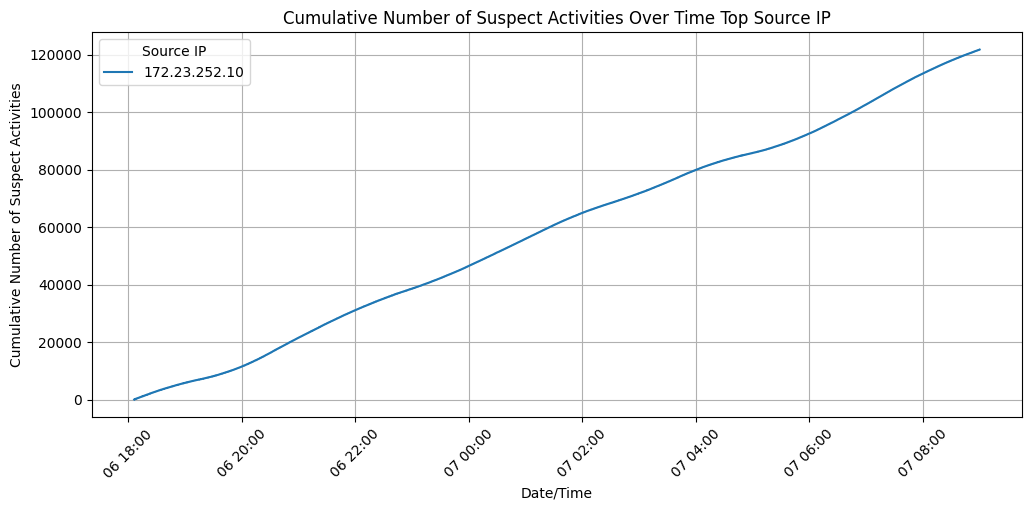

In [14]:
# line plot for each one of the top source IPs
plt.figure(figsize=(12, 5))
for ip in top_IP:
    ip_data = top_data[top_data['Source IP'] == ip]
    sns.lineplot(x='parsed_time', y='cumulative_count', data=ip_data, label=ip)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M')) 
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))  
plt.xlabel('Date/Time')
plt.ylabel('Cumulative Number of Suspect Activities')
plt.title('Cumulative Number of Suspect Activities Over Time Top Source IP')
plt.xticks(rotation=45)
plt.legend(title='Source IP')
plt.grid(True)
plt.show()

### 6 - Possible NBT-NS poisoning
Following the firewall attack, right after the firewall malfunction, connections using the **netbios-ns** protocol start appearing. They all use UDP packets and build short-lasting connections, which are torn down after less than two minutes. This could hint to NBT-NS poisoning, a technique to obtain the credentials of the users within the network, which can be used to further escalate the attack. On the other hand, it could be yet another way the attackers are using to build connections to the outside and transfer the obtained data, since the FTP connections have all been blocked. 

Below, we show the destination services that do not contain _tcp or _udp, which can be quite interesting to analyze. Then we focus on the least common ones, which are the most likely to be used by attackers, and investigate them.

In [90]:
# from data_firewall, extract all the logs where the Protocol entry does not contain any number
destination_service_strings = data_firewall[~data_firewall['Destination service'].astype(str).str.contains(r'\d')]
# print the occurrences of each unique value in the Destination service column
print(destination_service_strings['Destination service'].value_counts())

Destination service
http           21331506
ftp                1825
domain              752
netbios-ns          130
auth                 62
https                42
telnet               42
syslog                8
knetd                 6
ms-sql-s              4
wins                  3
pptp                  3
netbios-dgm           2
kpop                  2
ms-sql-m              1
ingreslock            1
Name: count, dtype: int64


In [20]:
# extract logs where the Destination service is the one of interest
service_of_interest = data_firewall[data_firewall['Destination service'] == 'ms-sql-s']
# print the logs formatted as a string
print(service_of_interest.to_string())

           Date/time  Syslog priority  Operation  Message code  Protocol    Source IP Destination IP  Source port  Destination port Destination service  Direction
77440     5 18:31:40                0          4            12         0  10.32.0.204   172.28.29.20           80              1433            ms-sql-s          2
1457931   5 20:50:36                0          4            12         0  10.32.0.201  172.28.29.172           80              1433            ms-sql-s          2
5229105   6 02:48:37                2          4            13         0   10.32.5.58      10.32.0.1         6667              1433            ms-sql-s          0
15808325  6 21:51:14                0          4            12         0  10.32.1.204    172.28.29.0           80              1433            ms-sql-s          2


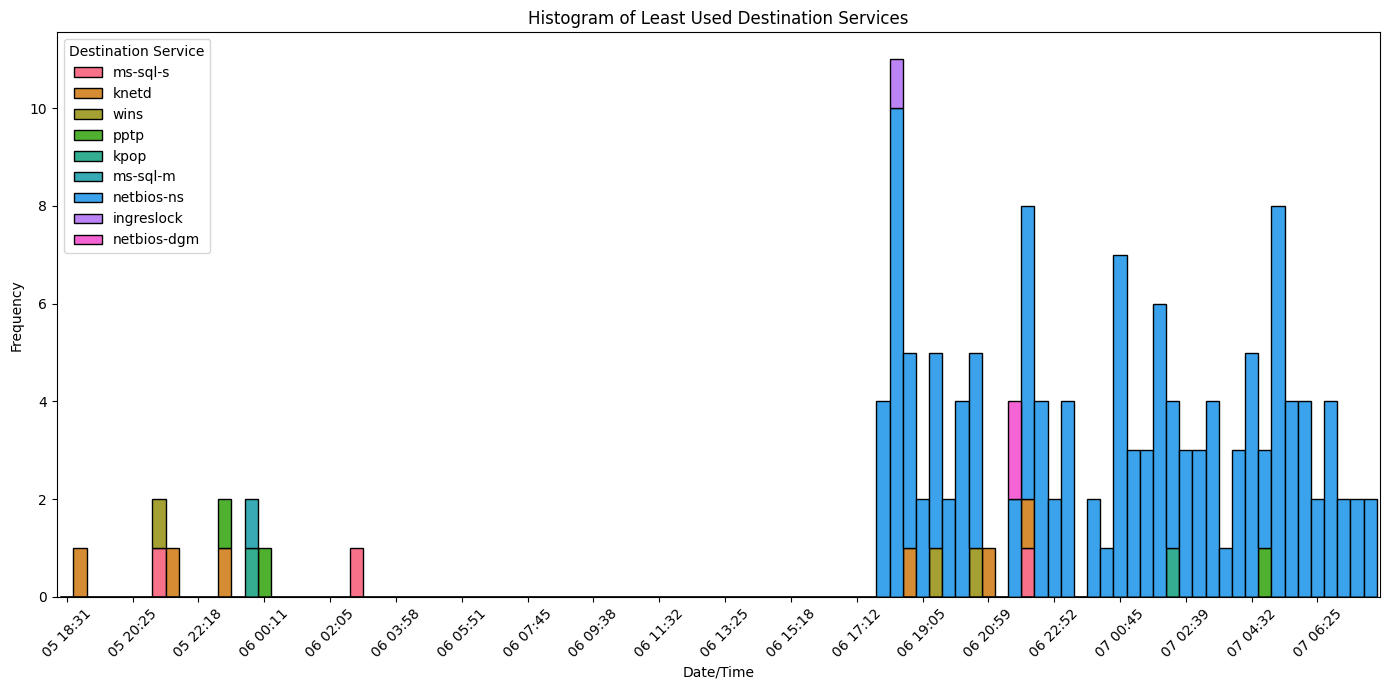

In [ ]:
# Filter out the services not of out interest
# filtered_services = destination_service_strings[~destination_service_strings['Syslog priority'].isin([0,1])]
filtered_services = destination_service_strings
filtered_services = filtered_services[~filtered_services['Destination service'].isin(['http', 'https', 'telnet', 'syslog', 'domain', 'ftp', 'auth'])]

# Get the unique services
unique_services = filtered_services['Destination service'].unique()

# Assign a different color to each service
colors = sns.color_palette('husl', len(unique_services))
color_mapping = dict(zip(unique_services, colors))

# Convert 'Date/time' to datetime
filtered_services['Date/time'] = pd.to_datetime(filtered_services['Date/time'], format='%d %H:%M:%S')

# Bin the data and prepare for stacking
bins = pd.date_range(start=filtered_services['Date/time'].min(), 
                     end=filtered_services['Date/time'].max(), 
                     periods=101)
stacked_data = {
    service: pd.cut(filtered_services[filtered_services['Destination service'] == service]['Date/time'], bins=bins).value_counts(sort=False)
    for service in unique_services
}

# Create a DataFrame for the stacked data
stacked_df = pd.DataFrame(stacked_data, index=bins[:-1]).fillna(0)

# Plot the stacked histogram
plt.figure(figsize=(14, 7))
stacked_df.plot(kind='bar', stacked=True, color=[color_mapping[service] for service in unique_services], edgecolor='black', width=1, ax=plt.gca())

plt.xlabel('Date/Time')
plt.ylabel('Frequency')
# plt.yscale('log')
plt.title('Histogram of Least Used Destination Services')
plt.legend(title='Destination Service')
plt.xticks(ticks=range(0, len(bins)-1, max(1, len(bins)//20)), labels=[bin.strftime('%d %H:%M') for bin in bins[:-1]][::max(1, len(bins)//20)], rotation=45)
plt.tight_layout()
plt.show()
